In [1]:
%matplotlib inline

In [2]:
import sys
import pickle
import random
from collections import defaultdict
from itertools import product

import Orange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

sys.path.append('../../pygkernels')
from pygkernels.data import Datasets

from sbm_neighbour_score import sbm_neighbour_score, graph_neighbour_score

In [3]:
kernels_names = [
    'Katz', 'logKatz',
    'For', 'logFor',
    'Comm', 'logComm',
    'Heat', 'logHeat',
    'NHeat', 'logNHeat',
    'SCT', 'SCCT',
    'RSP', 'FE',
    'PPR', 'logPPR',
    'ModifPPR', 'logModifPPR',
    'HeatPR', 'logHeatPR',
    'DF', 'logDF',
    'Abs', 'logAbs',
    'SP-CT'
]

shuffle = lambda x: sorted(x, key=lambda k: random.random())

def dict_argmax(dct, score_key):
    best_key = list(dct.keys())[0]
    best_val = dct[best_key]
    for k, v in dct.items():
        if v[score_key] > best_val[score_key]:
            best_key, best_val = k, v
    return best_key, best_val

CACHE_ROOT = '../../cache/cache'

def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for dataset, classifier_accuracy in results.items():
        if type(dataset) == tuple:
            dataset = '_'.join([str(x) for x in dataset])
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

# Analyze results of Datasets

In [4]:
DATASETS_RESULTS_ROOT = '../../cache/kkmeans_init_datasets'
datasets = [
    'cora_DB', 'cora_EC', 'cora_HA', 'cora_HCI', 'cora_IR', 'cora_Net',
    'dolphins',
    'eu-core',
    'eurosis',
    'football',
    'karate',
    'news_2cl1_0.1', 'news_2cl2_0.1', 'news_2cl3_0.1',
    'news_3cl1_0.1', 'news_3cl2_0.1', 'news_3cl3_0.1',
    'news_5cl1_0.1', 'news_5cl2_0.1', 'news_5cl3_0.1',
    'polblogs',
    'polbooks',
    'sp_school_day_1', 'sp_school_day_2'
]
actual_graphs = Datasets()

In [5]:
with open(f'{CACHE_ROOT}/datasets_inits_bestparam_byari_individual_0.1.pkl', 'rb') as f:
    results = pickle.load(f)
with open(f'{CACHE_ROOT}/datasets_modularity_0.1.pkl', 'rb') as f:
    modularity_results = pickle.load(f)

In [6]:
# table for modularity any3
results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(datasets, kernels_names):  # {dataset, {kernel_name: mean_bestari}}
    results_m3_dka[dataset][kernel_name] = np.mean(results_m3_dka[dataset][kernel_name])

dataset_meanari = {k: np.mean(list(v.values())) for k, v in results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(dataset_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

cora_Net: 0.18
cora_DB: 0.18
cora_EC: 0.27
cora_IR: 0.30
eu-core: 0.34
cora_HA: 0.38
news_5cl3_0.1: 0.42
news_5cl2_0.1: 0.49
cora_HCI: 0.51
news_5cl1_0.1: 0.61
news_3cl2_0.1: 0.62
news_3cl3_0.1: 0.66
news_2cl2_0.1: 0.67
polbooks: 0.69
sp_school_day_1: 0.72
news_3cl1_0.1: 0.73
news_2cl1_0.1: 0.73
polblogs: 0.73
sp_school_day_2: 0.74
eurosis: 0.74
news_2cl3_0.1: 0.83
football: 0.87
dolphins: 0.93
karate: 1.00


In [7]:
dataset_modularity = modularity_results
for dataset, modularity in sorted(list(modularity_results.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

cora_EC: 0.19
sp_school_day_1: 0.29
eu-core: 0.31
sp_school_day_2: 0.32
news_2cl2_0.1: 0.34
cora_Net: 0.35
karate: 0.37
dolphins: 0.37
news_2cl1_0.1: 0.38
cora_IR: 0.38
polblogs: 0.41
polbooks: 0.41
news_2cl3_0.1: 0.42
news_5cl3_0.1: 0.42
cora_DB: 0.43
news_3cl2_0.1: 0.46
news_5cl2_0.1: 0.50
news_3cl3_0.1: 0.51
news_3cl1_0.1: 0.53
cora_HCI: 0.53
football: 0.55
news_5cl1_0.1: 0.56
cora_HA: 0.61
eurosis: 0.70


/home/illusionww/Documents/GitHub/pygkernels-experiments/experiments/init/sbm_neighbour_score.py:53: RuntimeWarning: invalid value encountered in double_scalars
  p_in = incidence[i, j] / (cluster_sizes[i] * (cluster_sizes[i] - 1) / 2)


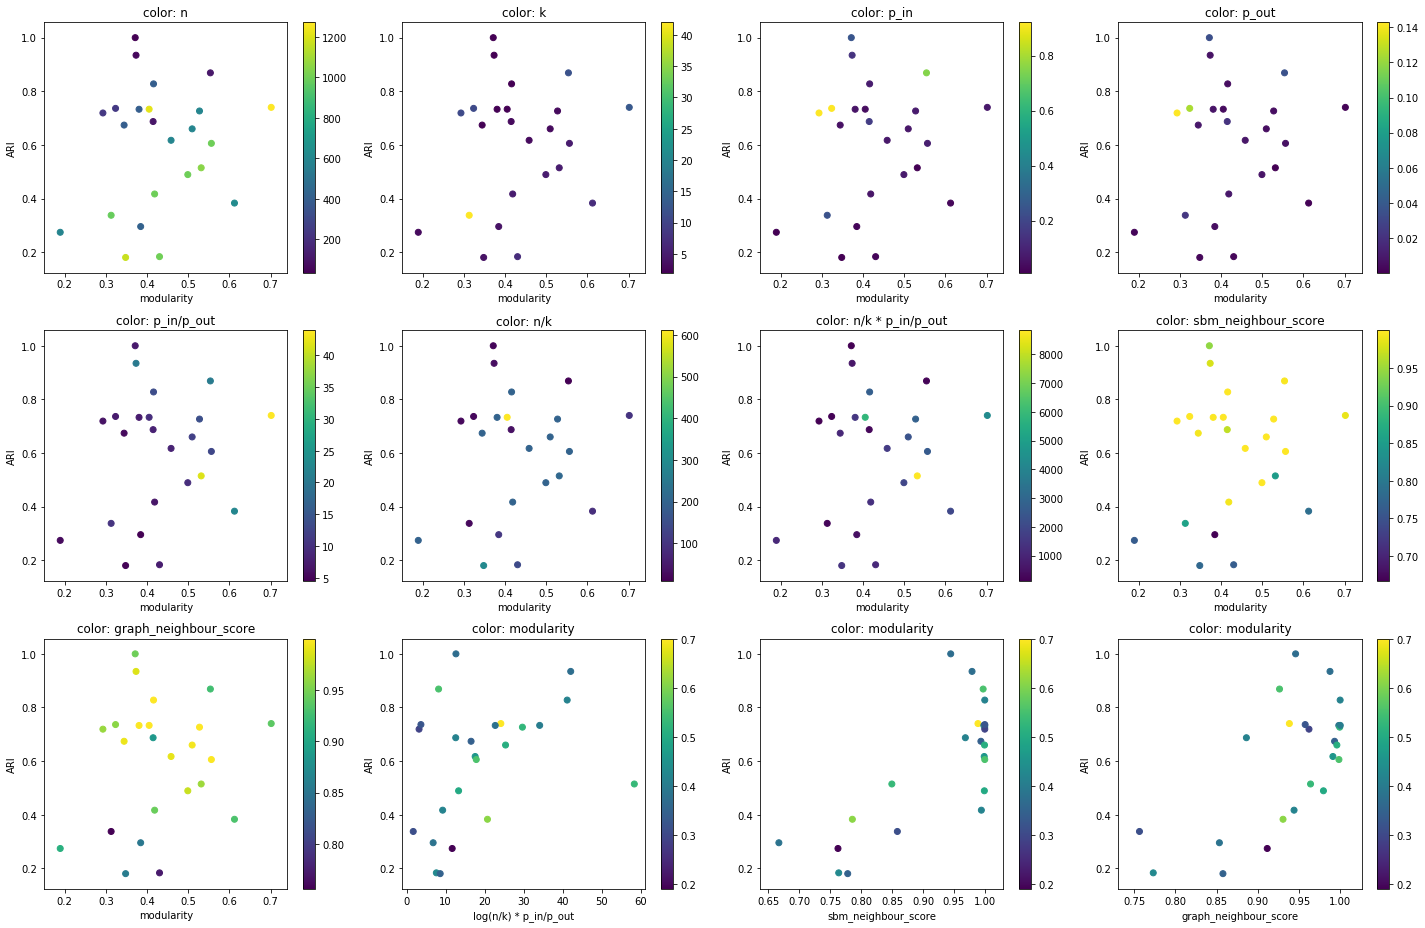

In [8]:
def extract_feature(dataset_name, feature):
    (A, partition), info = actual_graphs[dataset_name]
    n, k, p_in, p_out = info['n'], info['k'], info['p_in'], info['p_out']
    if feature == 'n':
        return n
    elif feature == 'k':
        return k
    elif feature == 'p_in':
        return p_in
    elif feature == 'p_out':
        return p_out
    elif feature == 'p_in/p_out':
        return p_in / p_out
    elif feature == 'n/k':
        return n / k
    elif feature == 'n/k * p_in/p_out':
        return (n / k) * (p_in / p_out)
    elif feature == 'log(n/k) * p_in/p_out':
        return np.log(n) / k * (p_in / p_out)
    elif feature == 'sbm_neighbour_score':
        return sbm_neighbour_score(int(n), int(k), p_in, p_out)
    elif feature == 'graph_neighbour_score':
        return graph_neighbour_score(A, partition)

# draw ari-modularity dependency
fig, ax = plt.subplots(3, 4, figsize=(20, 13))
ax = np.ravel(ax)
for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out', 'p_in/p_out', 'n/k', 'n/k * p_in/p_out', 'sbm_neighbour_score', 'graph_neighbour_score']):
    x, y, v = [], [], []
    for dataset in datasets:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
        v.append(extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v)
    ax[idx].set_xlabel('modularity')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])

idx = 9
x, y, v = [], [], []
for dataset in datasets:
    x.append(extract_feature(dataset, 'log(n/k) * p_in/p_out'))
    y.append(dataset_meanari[dataset])
    v.append(dataset_modularity[dataset])
sc = ax[idx].scatter(x, y, c=v)
ax[idx].set_xlabel('log(n/k) * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].set_title('color: modularity')
plt.colorbar(sc, ax=ax[idx])

idx = 10
x, y, v = [], [], []
for dataset in datasets:
    x.append(extract_feature(dataset, 'sbm_neighbour_score'))
    y.append(dataset_meanari[dataset])
    v.append(dataset_modularity[dataset])
sc = ax[idx].scatter(x, y, c=v)
ax[idx].set_xlabel('sbm_neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].set_title('color: modularity')
plt.colorbar(sc, ax=ax[idx])

idx = 11
x, y, v = [], [], []
for dataset in datasets:
    x.append(extract_feature(dataset, 'graph_neighbour_score'))
    y.append(dataset_meanari[dataset])
    v.append(dataset_modularity[dataset])
sc = ax[idx].scatter(x, y, c=v)
ax[idx].set_xlabel('graph_neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].set_title('color: modularity')
plt.colorbar(sc, ax=ax[idx])

plt.tight_layout()

## CD diagram

n_experiments: 4200


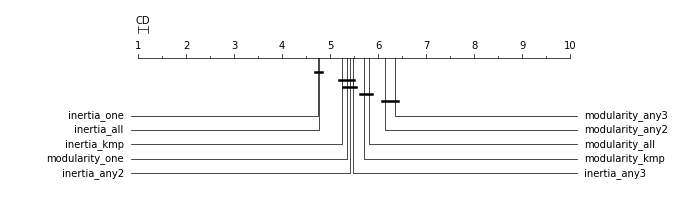

In [9]:
avranks, names, n_experiments = calc_avranks(results) # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

n_experiments: 168


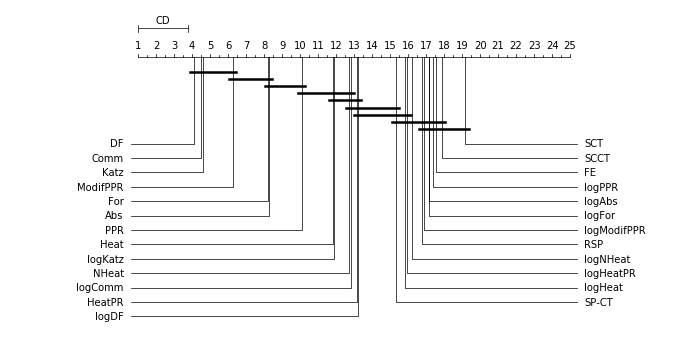

In [10]:
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

avranks, names, n_experiments = calc_avranks(results_modularity_any3)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

## Group datasets by measure ranking

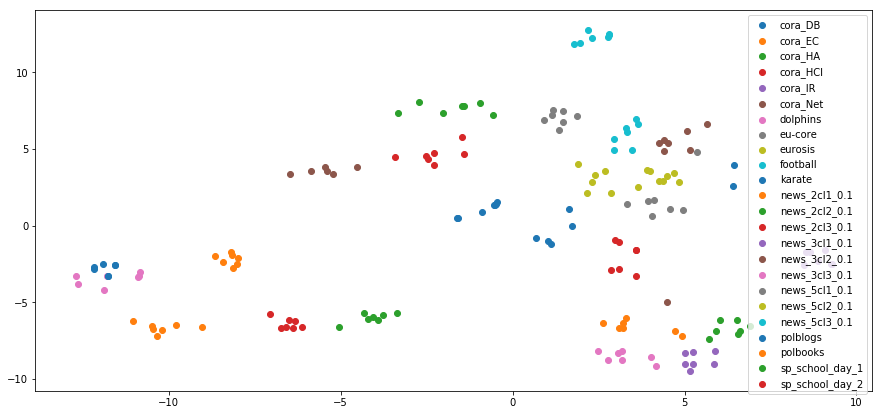

In [11]:
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {(dataset, graph_idx), {kernel_name: best_ari}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

dataset_graphidx_avranks = dict()
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks({'0': dataset_results})
    dataset_graphidx_avranks[dataset_name] = avranks
    
# TSNE
X_embedded = TSNE(n_components=2, learning_rate=100).fit_transform(list(dataset_graphidx_avranks.values()))

dataset_embedding = defaultdict(list)  # {dataset: [embedding]}
for (dataset, graph_idx), X_embedded_item in zip(list(dataset_graphidx_avranks.keys()), X_embedded):
    dataset_embedding[dataset].append(X_embedded_item)
    
plt.subplots(1, figsize=(15, 7))
for dataset, embedding in dataset_embedding.items():
    embedding = np.array(embedding)
    plt.scatter(embedding[:, 0], embedding[:, 1], label=dataset)
plt.legend()

In [12]:
results_modularity_any3 = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # {dataset: {graphidx: {kernel_name: best_ari}}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[dataset][graph_idx][kernel_name] = si_ari['modularity_any3']

dataset_avranks = dict()  # {dataset: avranks}
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks(dataset_results)
    dataset_avranks[dataset_name] = avranks

n_clusters = 3
# kmeans = KMeans(n_clusters=n_clusters)
kmeans = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
kmeans.fit(list(dataset_avranks.values()))

datasets_partition = []  # [[dataset]]
for class_idx in range(n_clusters):
    datasetss = [dataset_name for dataset_name, label in zip(list(dataset_avranks.keys()), kmeans.labels_) if label == class_idx]
    print(datasetss)
    datasets_partition.append(datasetss)

['cora_DB', 'cora_IR', 'cora_Net', 'eu-core', 'eurosis', 'football', 'news_2cl3_0.1', 'news_3cl2_0.1', 'news_5cl1_0.1', 'news_5cl2_0.1', 'news_5cl3_0.1', 'polblogs', 'sp_school_day_1', 'sp_school_day_2']
['cora_EC', 'cora_HA', 'cora_HCI', 'dolphins', 'karate', 'polbooks']
['news_2cl1_0.1', 'news_2cl2_0.1', 'news_3cl1_0.1', 'news_3cl3_0.1']


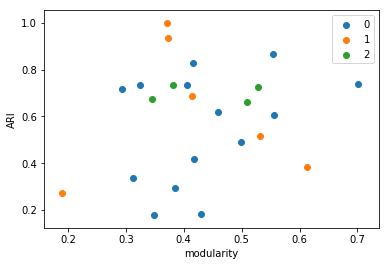

In [13]:
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]

    x, y = [], []
    for dataset in datasetss:
        x.append(modularity_results[dataset])
        y.append(dataset_meanari[dataset])
    plt.scatter(x, y, label=class_idx)
plt.xlabel('modularity')
plt.ylabel('ARI')
plt.legend()

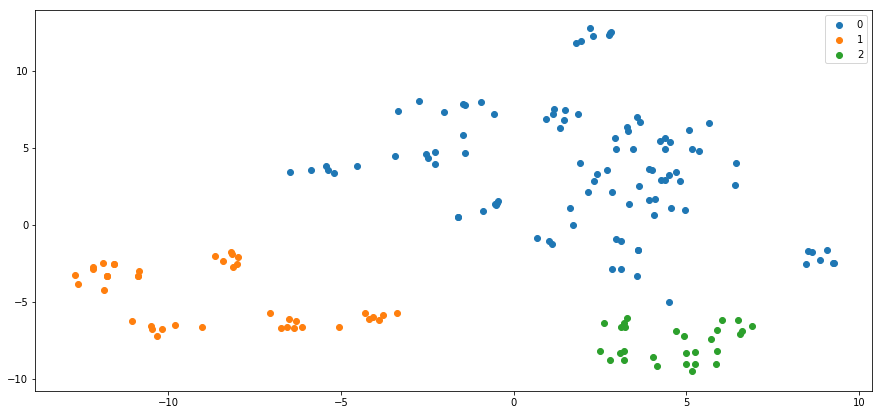

In [14]:
plt.subplots(1, figsize=(15, 7))
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    embedding_filtered = []
    for dataset in datasetss:
        embedding_filtered.extend(dataset_embedding[dataset])
    embedding_filtered = np.array(embedding_filtered)
    plt.scatter(embedding_filtered[:, 0], embedding_filtered[:, 1], label=class_idx)
plt.legend()

n_experiments: 98


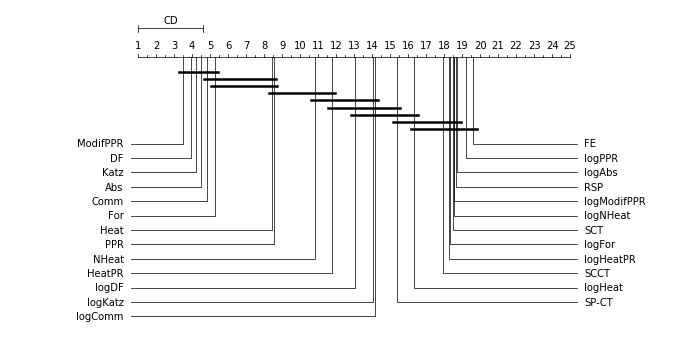

n_experiments: 42


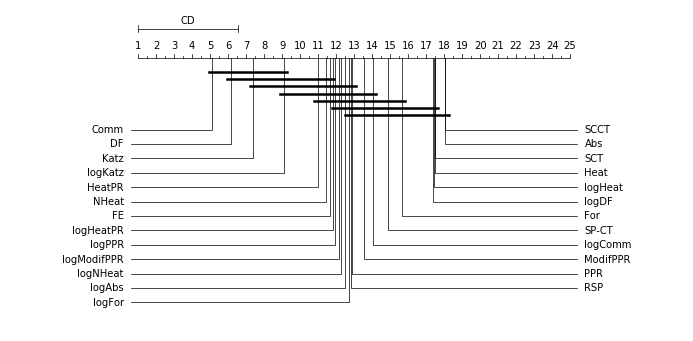

n_experiments: 28


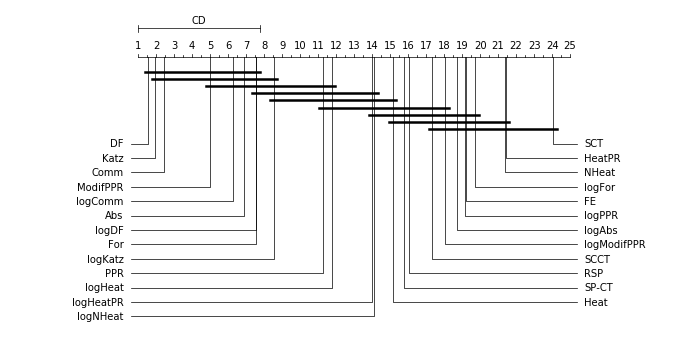

In [15]:
for group_idx, datasets_group in enumerate(datasets_partition):
    results_filtered = {k: v for k, v in results.items() if k[0] in datasets_group}
    results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
    for (dataset, kernel_name, graph_idx), si_ari in results_filtered.items():
        results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

    avranks, names, n_experiments = calc_avranks(results_modularity_any3)
    print(f'n_experiments: {n_experiments}')
    cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
    plt.show()